# Laptop Price Analysis & Ridge Regression
End-to-end workflow: Data cleaning → EDA → encoding → PolynomialFeatures + Ridge → evaluation.

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Load data

In [ ]:
filepath = '"laptop_pricing_dataset_mod1.csv"
df = pd.read_csv(filepath, header=0)
df.head()

,Unnamed: 0.1,Unnamed: 0,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_cm,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,0,0,Acer,4,IPS Panel,2,1,5,35.560,1.6,8,256,1.60,978
1,1,1,Dell,3,Full HD,1,1,3,39.624,2.0,4,256,2.20,634
2,2,2,Dell,3,Full HD,1,1,7,39.624,2.7,8,256,2.20,946
3,3,3,Dell,4,IPS Panel,2,1,5,33.782,1.6,8,128,1.22,1244
4,4,4,HP,4,Full HD,2,1,7,39.624,1.8,8,256,1.91,837


# 2.Data wrangling

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    238 non-null    int64  
 1   Unnamed: 0      238 non-null    int64  
 2   Manufacturer    238 non-null    object 
 3   Category        238 non-null    int64  
 4   Screen          238 non-null    object 
 5   GPU             238 non-null    int64  
 6   OS              238 non-null    int64  
 7   CPU_core        238 non-null    int64  
 8   Screen_Size_cm  234 non-null    float64
 9   CPU_frequency   238 non-null    float64
 10  RAM_GB          238 non-null    int64  
 11  Storage_GB_SSD  238 non-null    int64  
 12  Weight_kg       233 non-null    float64
 13  Price           238 non-null    int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 26.2+ KB


Round all values in column 'Screen_Size_cm' to nearest 2 decimal.


In [6]:
df['Screen_Size_cm'] = np.round(df['Screen_Size_cm'],2)
df[['Screen_Size_cm']].head()

,Screen_Size_cm
0,35.56
1,39.62
2,39.62
3,33.78
4,39.62


Drop the two unnecessary columns that have been added into the file, 'Unnamed: 0' and 'Unnamed: 0.1'. Use drop to delete these columns.

In [ ]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

# Evaluate the dataset for missing data
Check the missing values for each column.

In [ ]:
print(df.isnull().sum())

Manufacturer      0
Category          0
Screen            0
GPU               0
OS                0
CPU_core          0
Screen_Size_cm    4
CPU_frequency     0
RAM_GB            0
Storage_GB_SSD    0
Weight_kg         5
Price             0
dtype: int64


Note that values in "Weight_kg" attribute are continuous in nature, and some values are missing. Therefore, I replace the missing values of weight with the average value of the attribute.

In [ ]:
mean_weight = df["Weight_kg"].astype('float').mean(axis = 0)
df["Weight_kg"] = df["Weight_kg"].replace(np.nan, mean_weight)
df[["Weight_kg"]].head()

,Weight_kg
0,1.60
1,2.20
2,2.20
3,1.22
4,1.91


Note that values in "Screen_Size_cm" attribute are categorical in nature, and some values are missing. Therefore, I plan to replace the missing values of Screen Size with the most frequent value of the attribute.


In [ ]:
mode = df["Screen_Size_cm"].value_counts().idxmax()
df["Screen_Size_cm"]=df["Screen_Size_cm"].replace(np.nan,mode)
df[["Screen_Size_cm"]].head()

,Screen_Size_cm
0,35.56
1,39.62
2,39.62
3,33.78
4,39.62


In [ ]:
print(df.isnull().sum())

Manufacturer      0
Category          0
Screen            0
GPU               0
OS                0
CPU_core          0
Screen_Size_cm    0
CPU_frequency     0
RAM_GB            0
Storage_GB_SSD    0
Weight_kg         0
Price             0
dtype: int64


# Data Unit Standardization
The value of Screen_size usually has a standard unit of inches. Similarly, weight of the laptop is needed to be in pounds.


In [ ]:
df["Screen_Size_cm"] = df["Screen_Size_cm"]/2.54
df["Weight_kg"] = df["Weight_kg"]*2.205
df.rename(columns={"Weight_kg":"Weight_pounds","Screen_Size_cm":"Screen_Size_inch"},inplace = True)

# Data Normalization
Often it is required to normalize a continuous data attribute.

In [ ]:
df["CPU_frequency"] = df["CPU_frequency"]/df["CPU_frequency"].max()

# Binning
In this case, 3 bins for the attribute "Price" are created for further plotting. These bins would be named "Low", "Medium" and "High". The new attribute will be named "Price-binned".

In [ ]:
price_bins = np.linspace(df["Price"].min(),df["Price"].max(),4)
names = ["Low", "Medium", "High"]
df["price_bins"] = pd.cut(df["Price"],price_bins,labels=names, include_lowest = True)
df[["price_bins",'Price']].head()

,price_bins,Price
0,Low,978
1,Low,634
2,Low,946
3,Low,1244
4,Low,837


Also, plot the bar graph of these bins.

Text(0.5, 1.0, 'Price bins')

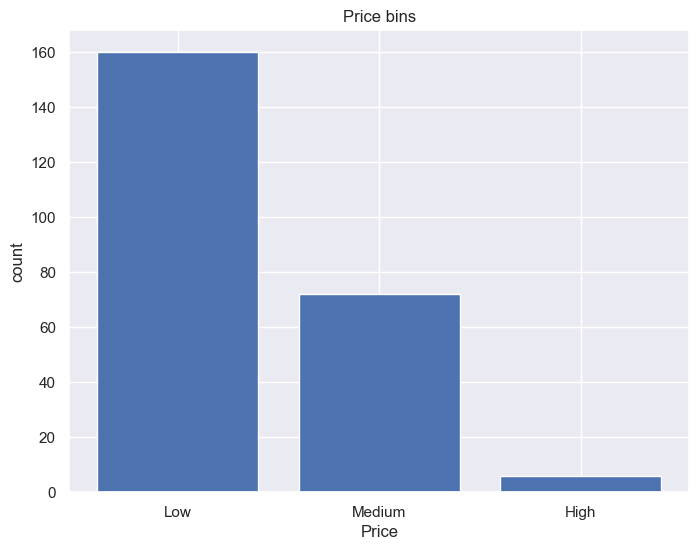

In [ ]:
plt.bar(names,df["price_bins"].value_counts())
plt.xlabel("Price")
plt.ylabel("count")
plt.title("Price bins")

# Indicator variables
Convert the "Screen" attribute of the dataset into 2 indicator variables, "Screen-IPS_panel" and "Screen-Full_HD". Then drop the "Screen" attribute from the dataset.


In [ ]:
dummies_screen = pd.get_dummies(df["Screen"])
dummies_screen.rename(columns={"IPS Panel":"Screen-IPS_panel",'Full HD':'Screen-Full_HD'},inplace = True)
df = pd.concat([df,dummies_screen], axis=1)
df = df.drop("Screen", axis=1)
df.head()

,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,price_bins,Screen-Full_HD,Screen-IPS_panel
0,Acer,4,2,1,5,14.000000,0.551724,8,256,3.52800,978,Low,False,True
1,Dell,3,1,1,3,15.598425,0.689655,4,256,4.85100,634,Low,True,False
2,Dell,3,1,1,7,15.598425,0.931034,8,256,4.85100,946,Low,True,False
3,Dell,4,2,1,5,13.299213,0.551724,8,128,2.69010,1244,Low,False,True
4,HP,4,2,1,7,15.598425,0.620690,8,256,4.21155,837,Low,True,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Manufacturer      238 non-null    object  
 1   Category          238 non-null    int64   
 2   GPU               238 non-null    int64   
 3   OS                238 non-null    int64   
 4   CPU_core          238 non-null    int64   
 5   Screen_Size_inch  238 non-null    float64 
 6   CPU_frequency     238 non-null    float64 
 7   RAM_GB            238 non-null    int64   
 8   Storage_GB_SSD    238 non-null    int64   
 9   Weight_pounds     238 non-null    float64 
 10  Price             238 non-null    int64   
 11  price_bins        238 non-null    category
 12  Screen-Full_HD    238 non-null    bool    
 13  Screen-IPS_panel  238 non-null    bool    
dtypes: bool(2), category(1), float64(3), int64(7), object(1)
memory usage: 21.4+ KB


In [ ]:
print(df.isnull().sum())

Manufacturer        0
Category            0
GPU                 0
OS                  0
CPU_core            0
Screen_Size_inch    0
CPU_frequency       0
RAM_GB              0
Storage_GB_SSD      0
Weight_pounds       0
Price               0
price_bins          0
Screen-Full_HD      0
Screen-IPS_panel    0
dtype: int64


# 3.Exploratory Data Analysis

# Visualize individual feature patterns
Generate regression plots for each of the parameters "CPU_frequency", "Screen_Size_inch" and "Weight_pounds" against "Price". Also, print the value of correlation of each feature with "Price".


(0.0, 3974.15)

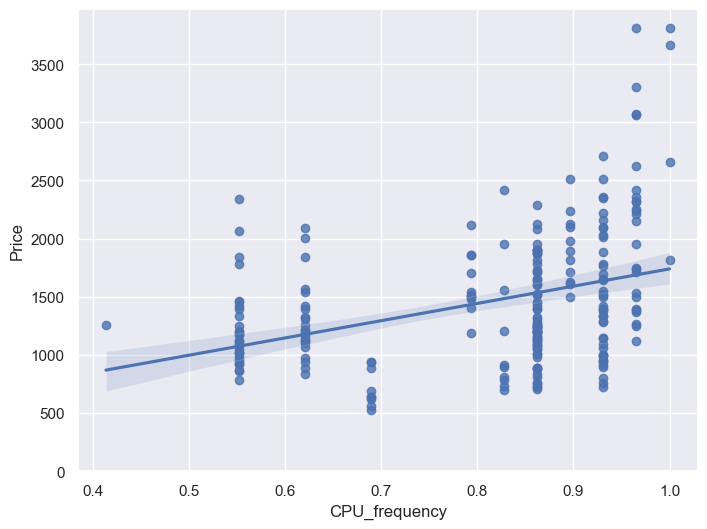

In [ ]:
# CPU_frequency plot
sns.regplot(x='CPU_frequency',y='Price',data = df)
plt.ylim(0,)

(0.0, 3974.15)

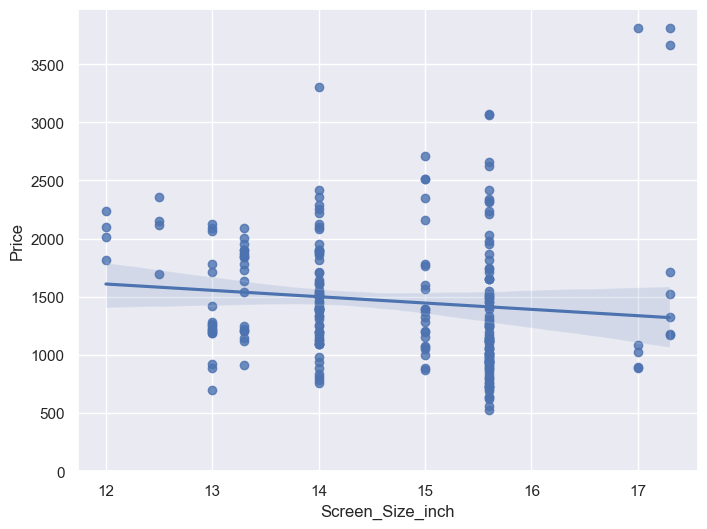

In [ ]:
sns.regplot(x='Screen_Size_inch', y='Price',data =df)
plt.ylim(0,)

(0.0, 3974.15)

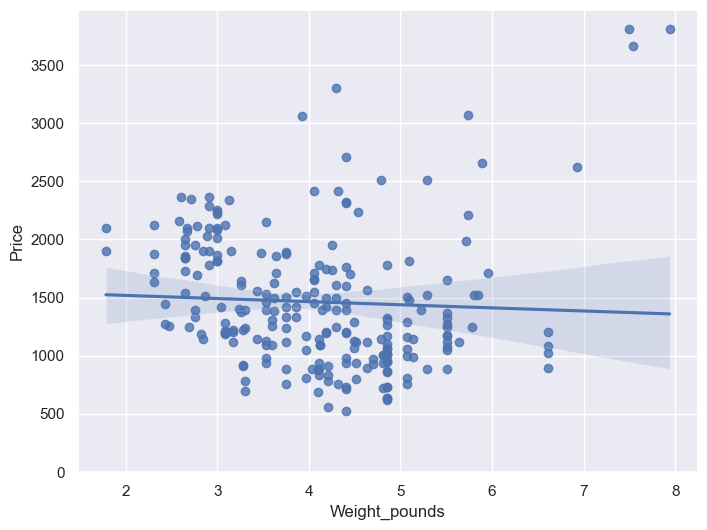

In [ ]:
sns.regplot(x='Weight_pounds', y='Price',data =df)
plt.ylim(0,)

In [ ]:
# Correlation values of the three attributes with Price
for x in ["CPU_frequency", "Screen_Size_inch" , "Weight_pounds"]:
    print(f"Correlation of Price and {x} is {df[[x,'Price']].corr()}")

Correlation of Price and CPU_frequency is                CPU_frequency     Price
CPU_frequency       1.000000  0.366666
Price               0.366666  1.000000
Correlation of Price and Screen_Size_inch is                   Screen_Size_inch     Price
Screen_Size_inch          1.000000 -0.110565
Price                    -0.110565  1.000000
Correlation of Price and Weight_pounds is                Weight_pounds     Price
Weight_pounds       1.000000 -0.050312
Price              -0.050312  1.000000


"CPU_frequency" has a 36% positive correlation with the price of the laptops. The other two parameters have weak correlation with price.  

CPU_frequency shows the highest correlation with Price, making it the most suitable predictor variable for price estimation.

### Categorical features
Generate Box plots for the different feature that hold categorical values. These features would be "Category", "GPU", "OS", "CPU_core", "RAM_GB", "Storage_GB_SSD"


(0.0, 3974.15)

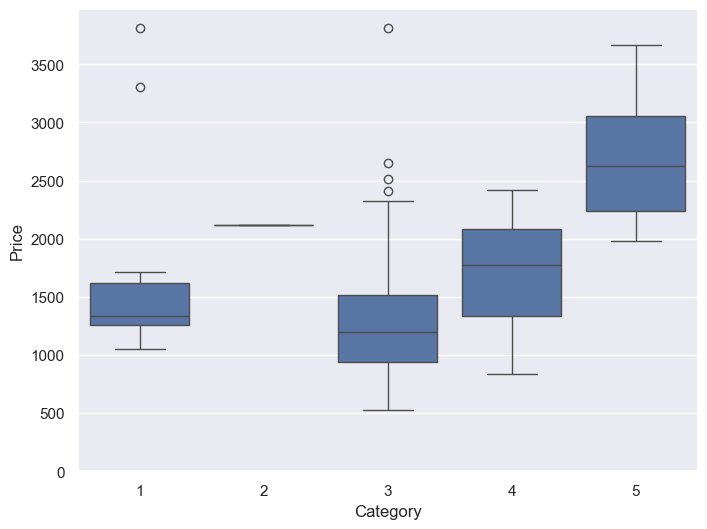

In [ ]:
sns.boxplot(x='Category',y='Price',data=df)
plt.ylim(0,)

<Axes: xlabel='GPU', ylabel='Price'>

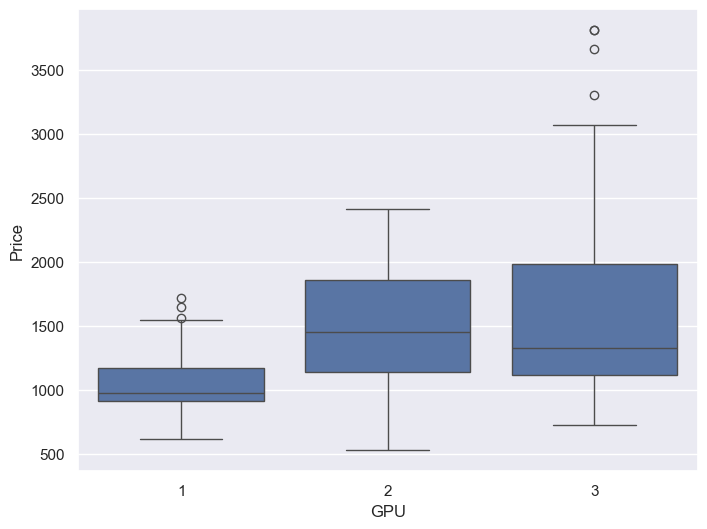

In [ ]:
# GPU Box plot
sns.boxplot(x='GPU',y='Price',data = df)

<Axes: xlabel='OS', ylabel='Price'>

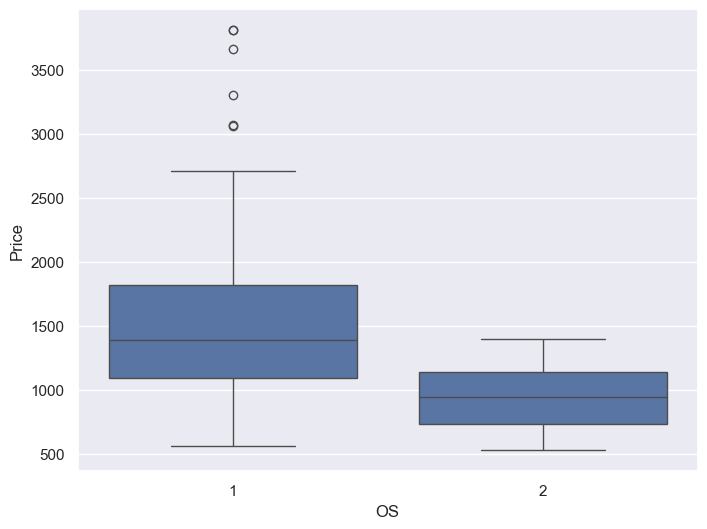

In [ ]:
# OS Box plot
sns.boxplot(x='OS',y='Price',data=df)

<Axes: xlabel='CPU_core', ylabel='Price'>

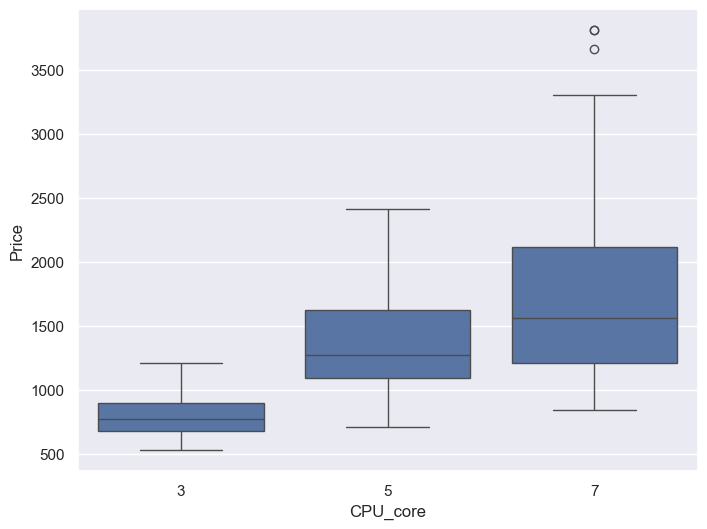

In [ ]:
# CPU_core Box plot
sns.boxplot(x='CPU_core',y='Price',data=df)

<Axes: xlabel='RAM_GB', ylabel='Price'>

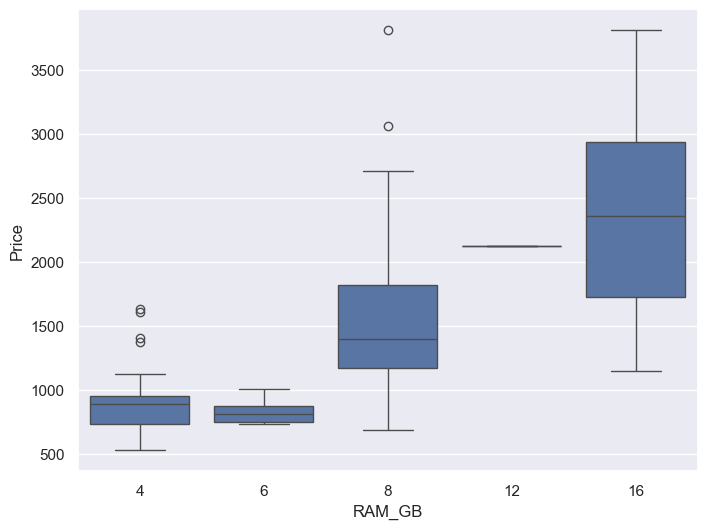

In [ ]:
# RAM_GB Box plot
sns.boxplot(x='RAM_GB',y='Price',data=df)

<Axes: xlabel='Storage_GB_SSD', ylabel='Price'>

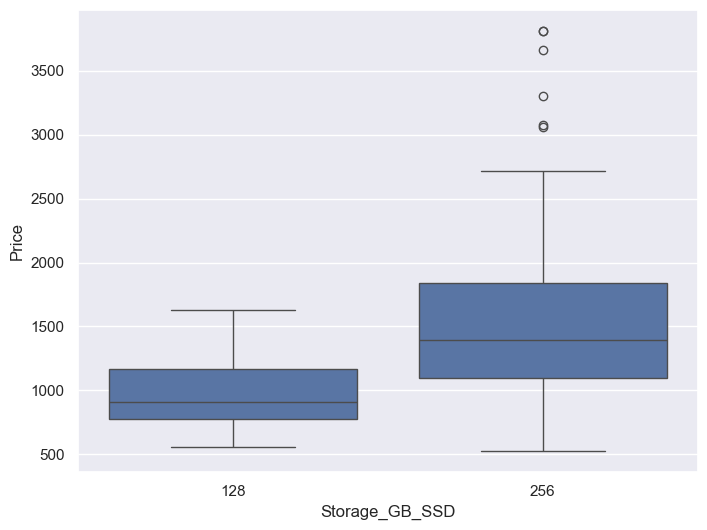

In [ ]:
# Storage_GB_SSD Box plot
sns.boxplot(x='Storage_GB_SSD',y='Price',data= df)

### Categorical features
Generate Box plots for the different feature that hold categorical values. These features would be "Category", "GPU", "OS", "CPU_core", "RAM_GB", "Storage_GB_SSD"


In [ ]:
df.describe(include='all')

,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,price_bins,Screen-Full_HD,Screen-IPS_panel
count,238,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238,238,238
unique,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2
top,Dell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,True,False
freq,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,161,161
mean,NaN,3.205882,2.151261,1.058824,5.630252,14.687951,0.813822,7.882353,245.781513,4.106221,1462.344538,NaN,NaN,NaN
std,NaN,0.776533,0.638282,0.235790,1.241787,1.165589,0.141860,2.482603,34.765316,1.078442,574.607699,NaN,NaN,NaN
min,NaN,1.000000,1.000000,1.000000,3.000000,12.000000,0.413793,4.000000,128.000000,1.786050,527.000000,NaN,NaN,NaN
25%,NaN,3.000000,2.000000,1.000000,5.000000,14.000000,0.689655,8.000000,256.000000,3.246863,1066.500000,NaN,NaN,NaN
50%,NaN,3.000000,2.000000,1.000000,5.000000,15.000000,0.862069,8.000000,256.000000,4.106221,1333.000000,NaN,NaN,NaN
75%,NaN,4.000000,3.000000,1.000000,7.000000,15.598425,0.931034,8.000000,256.000000,4.851000,1777.000000,NaN,NaN,NaN


# GroupBy and Pivot Tables

Group the parameters "GPU", "CPU_core" and "Price" to make a pivot table and visualize this connection using the pcolor plot.


In [ ]:
# Create the group
df.head(5)
df_task3 = df[["GPU", "CPU_core", "Price"]]
df_grp = df_task3.groupby(['GPU','CPU_core'],as_index=False)['Price'].mean()
print(df_grp)

   GPU  CPU_core        Price
0    1         3   769.250000
1    1         5   998.500000
2    1         7  1167.941176
3    2         3   785.076923
4    2         5  1462.197674
5    2         7  1744.621622
6    3         3   784.000000
7    3         5  1220.680000
8    3         7  1945.097561


In [ ]:
# Create the Pivot table
df_pivot = df_task3.pivot_table(values='Price',index='GPU',columns='CPU_core',aggfunc='mean')
print(df_pivot)

CPU_core           3            5            7
GPU                                           
1         769.250000   998.500000  1167.941176
2         785.076923  1462.197674  1744.621622
3         784.000000  1220.680000  1945.097561


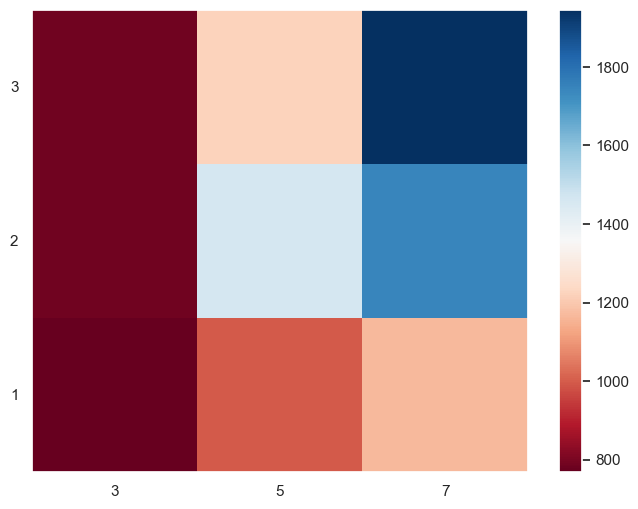

In [ ]:
# Create the Plot
fig, ax = plt.subplots()
im = ax.pcolor(df_pivot, cmap='RdBu')

#label names
row_labels = df_pivot.columns
col_labels = df_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(df_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(df_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

fig.colorbar(im)

# Pearson Correlation and p-values

Evaluate the Pearson Coefficient and the p-values for each parameter tested above. This will help with determining the parameters most likely to have a strong effect on the price of the laptops.


In [ ]:
for param in ['RAM_GB','CPU_frequency','Storage_GB_SSD','Screen_Size_inch','Weight_pounds','CPU_core','OS','GPU','Category']:
    pearson_coef, p_value = stats.pearsonr(df[param], df['Price'])
    print(param)
    print("The Pearson Correlation Coefficient for ",param," is", pearson_coef, " with a P-value of P =", p_value)

RAM_GB
The Pearson Correlation Coefficient for  RAM_GB  is 0.5492972971857846  with a P-value of P = 3.68156062884271e-20
CPU_frequency
The Pearson Correlation Coefficient for  CPU_frequency  is 0.3666655589258862  with a P-value of P = 5.502463350713293e-09
Storage_GB_SSD
The Pearson Correlation Coefficient for  Storage_GB_SSD  is 0.24342075521810302  with a P-value of P = 0.00014898923191724214
Screen_Size_inch
The Pearson Correlation Coefficient for  Screen_Size_inch  is -0.1105647127542506  with a P-value of P = 0.08876456732700744
Weight_pounds
The Pearson Correlation Coefficient for  Weight_pounds  is -0.05031225837751544  with a P-value of P = 0.4397693853433896
CPU_core
The Pearson Correlation Coefficient for  CPU_core  is 0.4593977773355116  with a P-value of P = 7.912950127009037e-14
OS
The Pearson Correlation Coefficient for  OS  is -0.2217298011482737  with a P-value of P = 0.0005696642559246758
GPU
The Pearson Correlation Coefficient for  GPU  is 0.28829819888814257  with 

# 4.Model Development

# Single Linear Regression

Create a single feature Linear Regression model that fits the pair of "CPU_frequency" and "Price" to find the model for prediction.


In [ ]:
lm = LinearRegression()
x=df[['CPU_frequency']]
y=df['Price']
lm.fit(x,y)
coeff=lm.coef_
intercept=lm.intercept_
yhat = lm.predict(x)

Generate the Distribution plot for the predicted values and that of the actual values. 

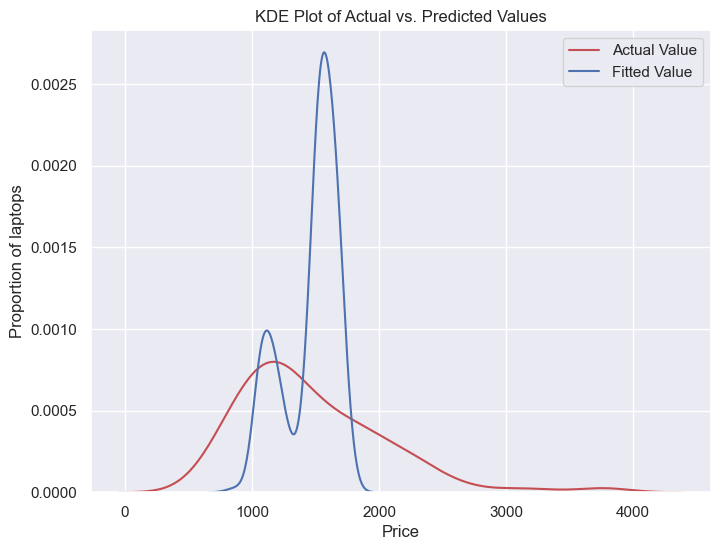

In [ ]:
ax1=sns.kdeplot(y,color="r",label="Actual Value")
sns.kdeplot(yhat,color="b",label="Fitted Value",ax=ax1)
plt.xlabel('Price')
plt.ylabel('Proportion of laptops')
plt.title('KDE Plot of Actual vs. Predicted Values')
plt.legend()
plt.show()

The model performed poorly. The predicted values (blue) are concentrated in a narrow range and fail to match the actual distribution (red) which is underfitting. It only captures the average trend but cannot predict low or high prices accurately.

Evaluate the Mean Squared Error and R^2 score values for the model. 


In [ ]:
print(mean_squared_error(y,yhat))
print(lm.score(x,y))

mse_slr = mean_squared_error(df['Price'], yhat)
r2_score_slr = lm.score(x, y)
print('The R-square for Linear Regression is: ', r2_score_slr)
print('The mean square error of price and predicted value is: ', mse_slr)

284583.4405868629
0.1344436321024326
The R-square for Linear Regression is:  0.1344436321024326
The mean square error of price and predicted value is:  284583.4405868629


R² ≈ 0.13 → the model explains only ~13% of the variation in price, which is very low.  
MSE ≈ 284,583 → large error, showing predictions are far from actual values.  
The linear model underfits badly and does not predict laptop prices well. You’d need more features (or a more complex model) for better performance.

# Multiple Linear Regression
The parameters which have a low enough p-value so as to indicate strong relationship with the 'Price' value are 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU' and 'Category'. Use all these variables to create a Multiple Linear Regression system. 


In [ ]:
z=df[[ 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU' , 'Category']]
lmm=LinearRegression()
lmm.fit(z,y)
ym_hat=lmm.predict(z)

Plot the Distribution graph of the predicted values as well as the Actual values

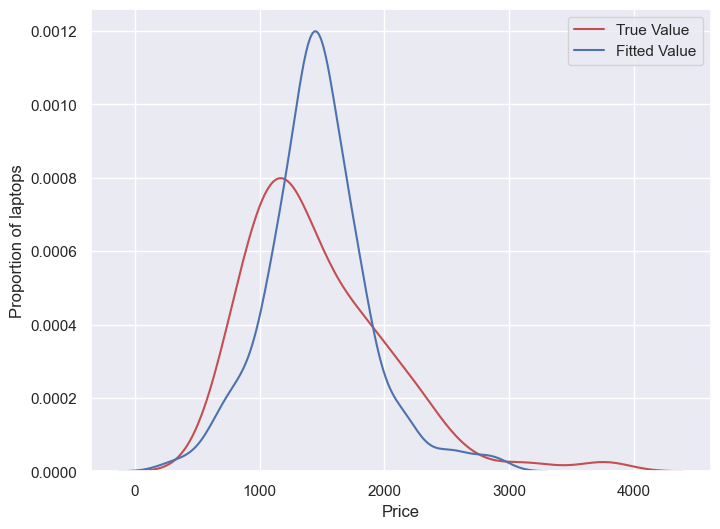

In [ ]:
# Write your code below and press Shift+Enter to execute
ax1=sns.kdeplot(y,color='r',label='True Value')
sns.kdeplot(ym_hat,color='b',label='Fitted Value',ax=ax1)
plt.xlabel('Price')
plt.ylabel('Proportion of laptops')
plt.legend()
plt.show()

In [ ]:
Rsquare=print(lmm.score(z,y))
MSE = print(mean_squared_error(y,ym_hat))

0.5082509055187374
161680.57263893107


Comparing with the single linear regression, this is much better. The multiple regression explains more than half of the variance in laptop prices and reduces prediction error compared to the simple linear model.

# Polynomial Regression
Use the variable "CPU_frequency" to create Polynomial features. Try this for 3 different values of polynomial degrees.

In [ ]:
f1=np.polyfit(df["CPU_frequency"],df['Price'],1)
p1=np.poly1d(f1)
print(p1)

f3=np.polyfit(df["CPU_frequency"],df["Price"],3)
p3=np.poly1d(f3)
print(p3)

f5=np.polyfit(df["CPU_frequency"],df["Price"],5)
p5=np.poly1d(f5)
print(p5)

 
1485 x + 253.7
           3             2
3.409e+04 x - 6.574e+04 x + 4.129e+04 x - 7238
           5            4             3             2
1.357e+06 x - 4.72e+06 x + 6.458e+06 x - 4.336e+06 x + 1.425e+06 x - 1.818e+05


Plot the regression output against the actual data points to note how the data fits in each case. To plot the polynomial response over the actual data points, create the function shown below.

In [ ]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(independent_variable.min(),independent_variable.max(),100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title(f'Polynomial Fit for Price ~ {Name}')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Price of laptops')

Call this function for the 3 models created and get the required graphs.

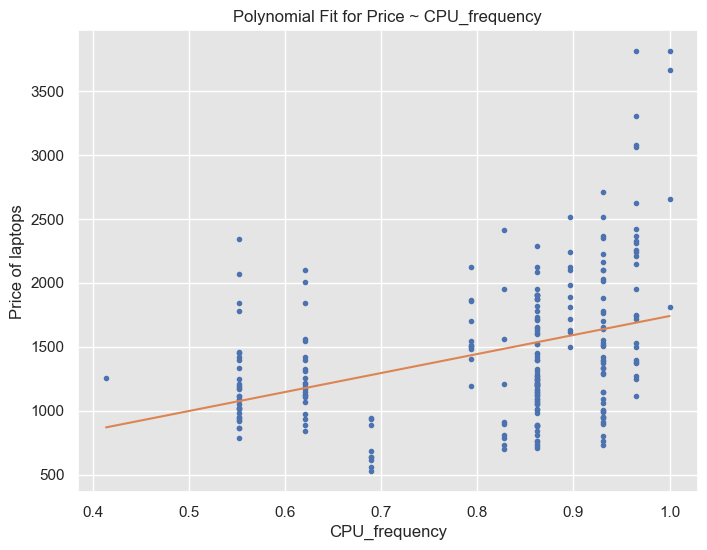

In [ ]:
# Call for function of degree 1
PlotPolly(p1, x, y, 'CPU_frequency')

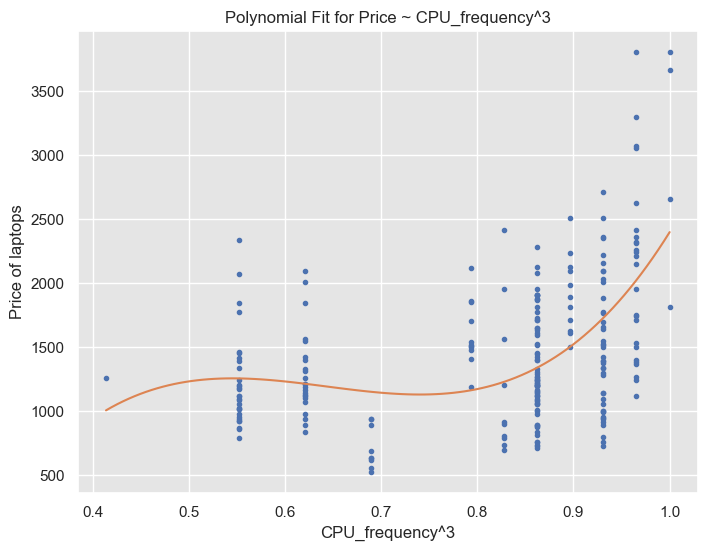

In [ ]:
# Call for function of degree 3
PlotPolly(p3,x,y,'CPU_frequency^3')

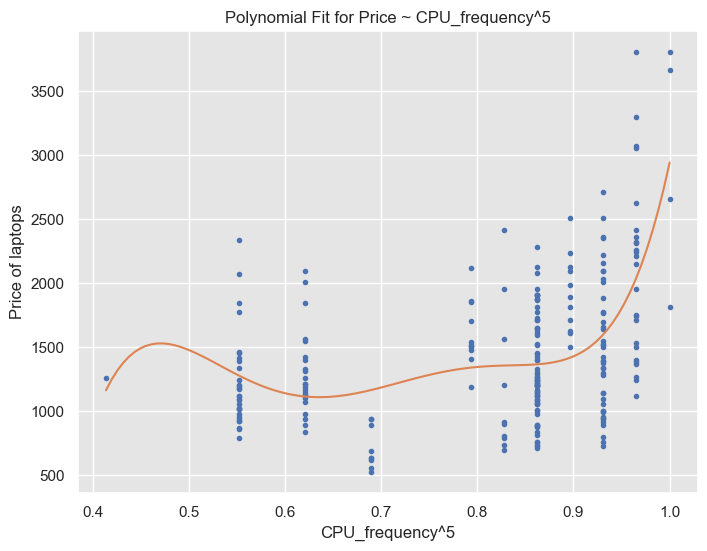

In [ ]:
# Call for function of degree 5
PlotPolly(p5,x,y,'CPU_frequency^5')

Also, calculate the R^2 and MSE values for these fits. For polynomial functions, the function sklearn.metrics.r2_score will be used to calculate R^2 values.

In [ ]:
from sklearn.metrics import mean_squared_error

print(r2_score(y,p1(x)))
print(r2_score(y,p3(x)))
print(r2_score(y,p5(x)))
print(mean_squared_error(y,p1(x)))
print(mean_squared_error(y,p3(x)))
print(mean_squared_error(y,p5(x)))

0.1344436321024326
0.26692640796531086
0.3030822706443571
284583.4405868629
241024.86303848776
229137.2954805459


The polynomial regression models improved the fit compared to simple linear regression. The R² score increased from 0.13 (linear) to 0.27 (degree 3) and 0.30 (degree 5), while the MSE decreased from ~284,583 to ~229,137. This indicates that higher-degree polynomials capture more of the variance in laptop prices, though the improvements are modest, suggesting other features beyond CPU frequency also play a key role in predicting prices.

# Pipeline
Create a pipeline that performs parameter scaling, Polynomial Feature generation and Linear regression. Use the set of multiple features as before to create this pipeline. 

In [ ]:
input=[('polynomial',PolynomialFeatures(degree=2)),('scale',StandardScaler()),('Model',LinearRegression())]
pipe=Pipeline(input)
pipe.fit(x,y)
yhat=pipe.predict(x)

Evaluate the MSE and R^2 values for the this predicted output.

In [ ]:
print('MSE for multi-variable polynomial pipeline is: ', mean_squared_error(y, yhat))
print('R^2 for multi-variable polynomial pipeline is: ', r2_score(y, yhat))

MSE for multi-variable polynomial pipeline is:  249022.66596751168
R^2 for multi-variable polynomial pipeline is:  0.24260120745423785


Now have seen that the values of R^2 increase as we go from Single Linear Regression to Multiple Linear Regression.


# 5.Model Evaluation and Refinement

# Using Cross validation to improve the model

Divide the dataset into x_data and y_data parameters. Here y_data is the "Price" attribute, and x_data has all other attributes in the data set.


In [ ]:
y_data = df['Price']
x_data = df.drop('Price',axis = 1)

Split the data set into training and testing subests such that you reserve 10% of the data set for testing purposes.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.1,random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 24
number of training samples: 214


Create a single variable linear regression model using "CPU_frequency" parameter. Print the R^2 value of this model for the training and testing subsets.

In [ ]:
lm=LinearRegression()
lm.fit(x_train[['CPU_frequency']],y_train)
lm.score(x_test[['CPU_frequency']],y_test)

-0.06599437350393766

Run a 4-fold cross validation on the model and print the mean value of R^2 score along with its standard deviation.

In [ ]:
scores = cross_val_score(lm,x_test[['CPU_frequency']],y_test,cv=4)
print([scores.mean(),scores.std()])

[-0.6033862975372097, 0.807601294621457]


The single-variable linear regression model using only CPU_frequency shows poor predictive performance (R² < 0) and unstable results across folds. This indicates that the model is underfitting and cannot generalize well. The next step is to address this limitation and explore techniques to reduce overfitting and improve model performance.

# Overfitting

Split the data set into training and testing components again, this time reserving 50% of the data set for testing.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.5,random_state=0)

To identify the point of overfitting the model on the parameter "CPU_frequency", I create polynomial features using the single attribute.  

Evaluate the R^2 scores of the model created using different degrees of polynomial features, ranging from 1 to 5. Save this set of values of R^2 score as a list.

In [ ]:
Rsqu_test=[]
order = [1,2,3,4,5]
for i in order:
    pr=PolynomialFeatures(degree=i)
    x_train_pr = pr.fit_transform(x_train[['CPU_frequency']])
    x_test_pr = pr.transform(x_test[['CPU_frequency']])
    lm.fit(x_train_pr,y_train)
    Rsquare=lm.score(x_test_pr,y_test)
    Rsqu_test.append(Rsquare)
    print("Rsquare with degree =",i,"is",Rsquare)

Rsquare with degree = 1 is 0.05322174176198147
Rsquare with degree = 2 is -0.02692081867900087
Rsquare with degree = 3 is 0.05156345792558559
Rsquare with degree = 4 is -0.9948137915478572
Rsquare with degree = 5 is -1.3759360956286337


Plot the values of R^2 scores against the order. Note the point where the score drops.

Text(0.5, 1.0, 'R^2 using test data')

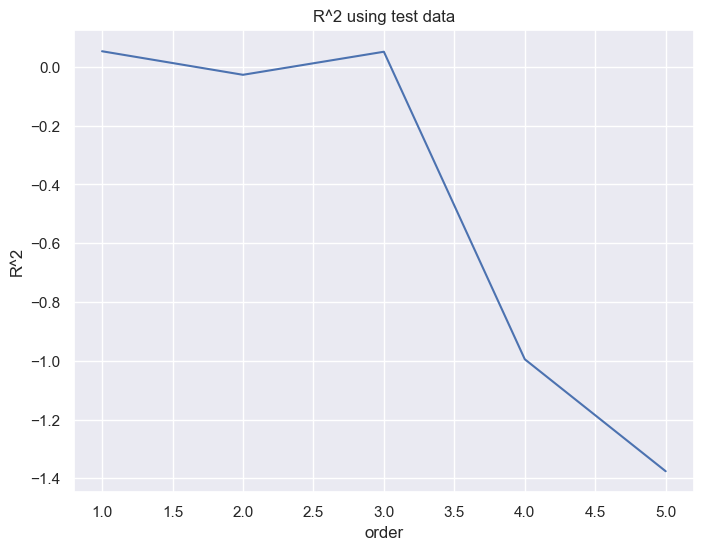

In [ ]:
plt.plot(order,Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 using test data')

# Ridge Regression

Now consider that I have multiple features, i.e. 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU' and 'Category'.  
- Create a polynomial feature model that uses all these parameters with degree=2. 
- Create the training and testing attribute sets.

In [ ]:
pr=PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU' , 'Category']])
x_test_pr=pr.transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU' , 'Category']])

Create a Ridge Regression model and evaluate it using values of the hyperparameter alpha ranging from 0.001 to 1 with increments of 0.001. 
Create a list of all Ridge Regression R^2 scores for training and testing data. 

In [ ]:
Rsq_test=[]
Rsq_train=[]
alpha = np.arange(0.001,1,0.001)
pbar=tqdm(alpha)
for alpha in pbar:
    RidgeModel = Ridge(alpha=alpha)
    RidgeModel.fit(x_train_pr,y_train)
    rsquare_train=RidgeModel.score(x_train_pr,y_train)
    rsquare_test=RidgeModel.score(x_test_pr,y_test)
    Rsq_train.append(rsquare_train)
    Rsq_test.append(rsquare_test)    
print(max(Rsq_test))
print(type(alpha))

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:00<00:00, 2213.65it/s]

0.42390631868511264
<class 'numpy.float64'>


Plot the R^2 values for training and testing sets with respect to the value of alpha

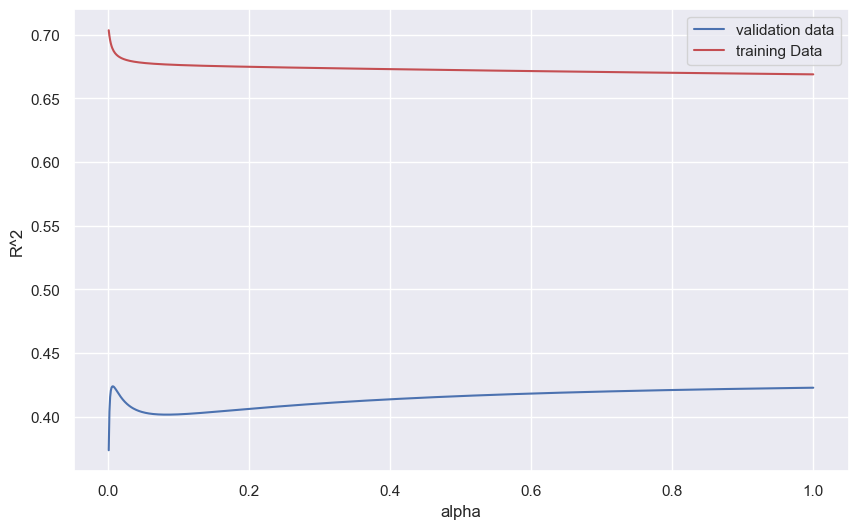

In [ ]:
plt.figure(figsize=(10, 6))  
alpha = np.linspace(0.001, 1, len(Rsq_test))
plt.plot(alpha, Rsq_test, label='validation data')
plt.plot(alpha, Rsq_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

Ridge regression introduces the regularization parameter α to control model complexity. As α increases, the R² value for the training set decreases slightly while the R² for the test set improves, indicating that Ridge regression effectively reduces overfitting and enhances the model’s generalization ability. Overall, the model performance remains stable across different α values, with the test R² reaching around 0.42, which is considerably better than the initial linear regression. This shows that Ridge regression successfully improves performance on unseen data by penalizing large coefficients.

# Grid Search

Using the raw data and the same set of features as used above, use GridSearchCV to identify the value of alpha for which the model performs best. Create a Ridge instance and run Grid Search using a 4 fold cross validation.

In [ ]:
parameters1 = [{'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}]
RR=Ridge()
grid = GridSearchCV(RR,parameters1,cv=4)

Fit the Grid Search to the training data.

In [ ]:
grid.fit(x_train_pr,y_train)

Print the R^2 score for the test data using the estimator that uses the derived optimum value of alpha.


In [ ]:
grid.fit(x_train_pr,y_train)
BestRR=grid.best_estimator_
print(BestRR.score(x_test_pr, y_test))

0.42236796465447235


The results show that the optimal model achieved a test R² of 0.42, which is consistent with the best outcome observed in the Ridge regression analysis. This confirms the effectiveness of hyperparameter tuning and demonstrates that Grid Search provides a more automated and reliable way to identify the best parameter values. By doing so, it further optimizes the Ridge model and ensures stronger generalization performance.